# HW08 - Instrumental Variables (due November 23rd)

In this homework you will practice with running IV regressions with python. You will investigate once more the effect of schooling on earnings, but this time the instrument for education you will use is college proximity to individuals houses (reference paper by [Card, 1993](https://davidcard.berkeley.edu/papers/geo_var_schooling.pdf)).

More in detail, there are two instruments that can be exploited in this context. Both are binary variables taking value 1 if either a 2-years or 4-years college is present in the area where the individual lives.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.iv import IV2SLS
from statsmodels.iolib.summary2 import summary_col
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

df = pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta')
pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta', iterator=True).variable_labels()

{'id': '',
 'nearc2': '=1 if near 2 yr college, 1966',
 'nearc4': '=1 if near 4 yr college, 1966',
 'educ': 'years of schooling, 1976',
 'age': 'in years',
 'fatheduc': "father's schooling",
 'motheduc': "mother's schooling",
 'weight': 'NLS sampling weight, 1976',
 'momdad14': '=1 if live with mom, dad at 14',
 'sinmom14': '=1 if with single mom at 14',
 'step14': '=1 if with step parent at 14',
 'reg661': 'regional dummy, 1966',
 'reg662': '',
 'reg663': '',
 'reg664': '',
 'reg665': '',
 'reg666': '',
 'reg667': '',
 'reg668': '',
 'reg669': '',
 'south66': '=1 if in south in 1966',
 'black': '=1 if black',
 'smsa': '=1 in in SMSA, 1976',
 'south': '=1 if in south, 1976',
 'smsa66': '=1 if in SMSA, 1966',
 'wage': 'hourly wage in cents, 1976',
 'enroll': '=1 if enrolled in school, 1976',
 'kww': 'knowledge world of work score',
 'iq': 'IQ score',
 'married': '=1 if married, 1976',
 'libcrd14': '=1 if lib. card in home at 14',
 'exper': 'age - educ - 6',
 'lwage': 'log(wage)',
 'expe

In [2]:
# clean data
df.dropna(inplace = True)

### OLS

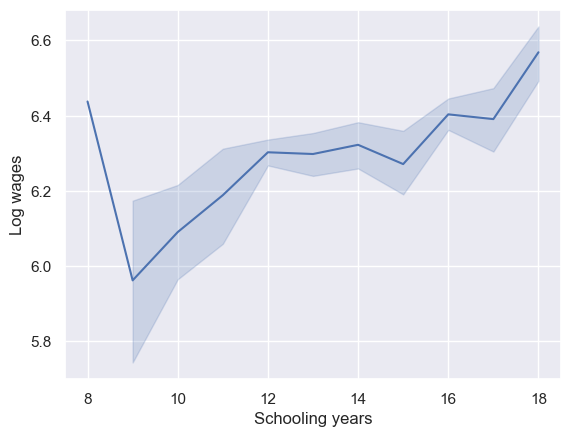

In [3]:
##plot log wages against education
sns.set_theme()
plot = sns.lineplot(data=df, y ='lwage', x='educ')
# ci is the size of the confidence interval to draw when aggregating.
plot.set(xlabel='Schooling years', ylabel='Log wages')
plt.show()

In [4]:
##Regress log wages (lwage) against education and include controls, use robust standard errors.

ols = smf.ols('lwage ~ educ + black + fatheduc + motheduc + iq', data = df).fit(cov_type = 'hc1')
ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     18.80
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           3.37e-18
Time:                        12:37:38   Log-Likelihood:                -829.83
No. Observations:                1600   AIC:                             1672.
Df Residuals:                    1594   BIC:                             1704.
Df Model:                           5                                         
Covariance Type:                  hc1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7510      0.093     62.050      0.000       5.569       5.933
educ           0.0297      0.006      5.255      0.000       0.019       0.041
black         -0.1458      0.037     -3.963      0.000      -0.218      -0.074
fatheduc      -0.0037      0.004     -0.927      0.354      -0.012       0.004
motheduc       0.0061      0.005      1.282      0.200      -0.003       0.015
iq             0.0015      0.001      1.669      0.095      -0.000       0.003
==============================================================================
Omnibus:                       26.580   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.760
Skew:                          -0.252   Prob(JB):                     2.09e-07
Kurtosis:                       3.456   Cond. No.                         906.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

**What are other possible confunders?**

Unobserved skills or ability

### 2SLS

You will use only on proximity to a 4-years college ($nearc4$) as instrument. 

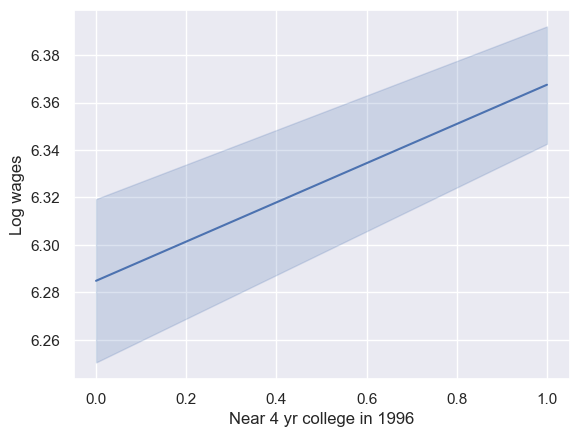

In [5]:
##plot log wages against nearc4
plot = sns.lineplot(data=df, y ='lwage', x='nearc4')
plot.set(xlabel='Near 4 yr college in 1996', ylabel='Log wages')
plt.show()

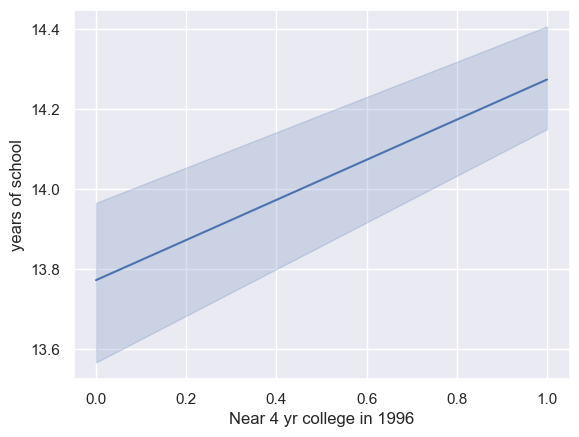

In [6]:
##plot education against nearc4
plot = sns.lineplot(data=df, y ='educ', x='nearc4')
plot.set(xlabel='Near 4 yr college in 1996', ylabel='years of school')
plt.show()

**If you run an IV regression of log wages on education, using college proximity as an instrument for education, what would you expect the sign of the coefficient on education to be? Why?**

The plots above is an indication that the first stage and reduced form coefficients are directly correlated. So we can expect a positive sign.

In [7]:
##run a regression of education on nearc4, adding the controls you selected before and using robust standard errors
fs = smf.ols('educ ~ nearc4 + black + fatheduc + motheduc + iq', data = df).fit(cov_type = 'hc1')

In [8]:
##predict education from the previous regression.
df['edu_predict'] = fs.predict()
df['edu_predict']


1       12.497295
2       14.371422
3       13.223360
4       13.614688
5       12.758025
          ...    
2980    11.983596
2993    12.718344
2994    13.292879
2997    14.787067
3000    13.055963
Name: edu_predict, Length: 1600, dtype: float64

In [9]:
##run a regression of log wages on education and controls using robust standard errors
twosls = smf.ols('lwage ~ edu_predict + black + fatheduc + motheduc + iq ', df).fit(cov_type = 'hc1')

In [10]:
##compare the 2sls and ols estimates 
print(summary_col([ols, twosls], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['educ', 'edu_predict']))


               lwage I lwage II
-------------------------------
educ           0.030           
               (0.006)         
edu_predict            0.305   
                       (0.092) 
Intercept      5.751   4.485   
               (0.093) (0.431) 
black          -0.146  -0.389  
               (0.037) (0.090) 
fatheduc       -0.004  -0.041  
               (0.004) (0.013) 
iq             0.002   -0.017  
               (0.001) (0.006) 
motheduc       0.006   -0.022  
               (0.005) (0.010) 
R-squared      0.059   0.048   
R-squared Adj. 0.056   0.045   
N              1600    1600    
Standard errors in parentheses.


**What do you think the difference in the estimates is due to?**

The IV coefficient is larger than the OLS one, suggesting that the OLS estimate is biased downward. This can have three different explanations:

There is an negative omitted variable bias in the OLS estimate
There is attenuation bias in the OLS estimate due to measurament error in the explanatory variable (education)
The effect of education is larger for compliers, that is individuals who would shift their level of education depending on the value of the instrument

### IV analysis

In [11]:
##use IV2sls to run the regression of log wages on education. using college proximity as an instrument for education
##add the same controls as 
from linearmodels.iv import IV2SLS

exog = sm.add_constant(df[['black', 'fatheduc', 'motheduc', 'iq']])
iv2sls = IV2SLS(df.lwage, exog, df.educ, df.nearc4).fit(cov_type='robust')
iv2sls

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                  lwage   R-squared:                     -1.4156
Estimator:                    IV-2SLS   Adj. R-squared:                -1.4232
No. Observations:                1600   F-statistic:                    30.259
Date:                Wed, Nov 16 2022   P-value (F-stat)                0.0000
Time:                        12:37:38   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.4848     0.7159     6.2643     0.0000      3.0816      5.8880
black         -0.3887     0.1527    -2.5446     0.0109     -0.6881     -0.0893
fatheduc      -0.0415     0.0221    -1.8790     0.0603     -0.0847      0.0018
motheduc      -0.0220     0.0173    -1.2744     0.2025     -0.0559      0.0118
iq            -0.0166     0.0102    -1.6339     0.1023     -0.0365      0.0033
educ           0.3046     0.1531     1.9900     0.0466      0.0046      0.6047
==============================================================================

Endogenous: educ
Instruments: nearc4
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x1358d3dc0

**Compare the estimate with the one found at the previous point.**

The estimates are the same because the IV function from linearmodels estimates the coefficient via 2 stage least squares.